# Max Feinglass PUI Homework 10
## The LAST PUI Homework
### 12-13-2015

In [1]:
%pylab inline
import pylab as pl
import pandas as pd
import numpy as np
from sklearn import preprocessing
import geopandas as gp
import os
import scipy.stats
from sklearn.cluster import KMeans
import zipfile
pl.style.use('ggplot')

Populating the interactive namespace from numpy and matplotlib


Bring in the geopanda for zips only in NYC

In [2]:
geo_df = gp.read_file(os.path.expandvars('nyc-zip-code-tabulation-areas-polygons.geojson'))

All we need are the zip codes so isolate those in a new dataframe.  

In [3]:
geo_zip = pd.DataFrame()
geo_df['zip'] = geo_df['postalCode']
geo_zip['zipkey'] = geo_df['zip'].astype('float')

Create a list labeling the years of intrest

In [4]:
years = ['94', '95', '96', '97', '98', '99', '00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13']

I could not get the zip package to work with my python so I have uploaded the txt files to my reposotory and unzipped them mannualy.  Please be kind if this causes my notebook to fail as I put a lot of work into this notebook and don't want the fact that I had a hard time unzipping a file to take away from my clustering and panda wrangling.

### GETTING PANDAS TO SET UP DATA CORRECTLY

Loop through each file and change the zipcode and est columns headers into something that is consistent with one another.  Create a list of data frames for each year.

In [41]:
#fname = "zbp94totals.zip"
all_years = []
temp_df = pd.DataFrame()

for i in years:
    fname = 'zbp%stotals.txt' %i
    temp_df = pd.read_csv(fname)
    try:
        temp_df['zipkey'] = temp_df['ZIP']
    except:
        temp_df['zipkey'] = temp_df['zip']
    try:
        temp_df['estkey'] = temp_df['EST']
    except:
        temp_df['estkey'] = temp_df['est']
    
    temp_df = temp_df[['zipkey','estkey']]
    all_years.append(temp_df)


Loop though the list and merge each 'est' column onto a master data frame indexed by zipcode

In [58]:
time = pd.DataFrame()
time['zipkey'] = all_years[0]['zipkey']
for i in range(len(all_years)):
    time = pd.merge(time, all_years[i], left_on = 'zipkey', right_on= 'zipkey', how = 'inner')
time.columns = ['zipcode']+years

Use the GeoJSON file to limit scope to only NYC zipcodes

In [59]:
time = pd.merge(time, geo_zip, left_on = 'zipcode', right_on = 'zipkey', how = 'inner')
time = time.drop_duplicates()
zipcodes = time['zipcode']

Whiten the data by first subtracting the mean of each row from each entry and then dividing each entery by the row's standard deviation.  Clean up data frame by indexing by zipcode and droping not est releated information.

In [60]:
time = time.sub(time.mean(axis=1), axis=0)
time = time.div(time.std(axis=1), axis=0)
time = time.dropna()
time = time.drop('zipcode', axis = 1 )
time = time.drop('zipkey', axis = 1 )
time = time.set_index(zipcodes)
time.head()

,94,95,96,97,98,99,00,01,02,03,04,05,06,07,08,09,10,11,12,13
zipcode,,,,,,,,,,,,,,,,,,,,
10001,-0.606478,-0.498091,-0.513923,-0.417715,-0.295932,-0.321506,-0.219209,-0.376309,-0.433546,-0.502963,-0.154664,-0.225298,-0.099862,0.063327,-0.030446,-0.233823,-0.311764,-0.328813,-0.319071,-0.272793
10002,-0.598853,-0.583328,-0.538971,-0.481308,-0.501712,-0.465340,-0.380175,-0.262187,-0.383724,-0.324730,-0.258639,-0.200532,-0.198757,-0.199201,-0.196539,-0.159280,-0.116254,-0.098512,-0.079882,-0.064801
10003,-0.600710,-0.535190,-0.513530,-0.449634,-0.387904,-0.382490,-0.369494,-0.413355,-0.405774,-0.358122,-0.319135,-0.269859,-0.247117,-0.171308,-0.159395,-0.144234,-0.136653,-0.111744,-0.081962,-0.047848
10004,-0.374957,-0.371452,-0.367947,-0.352368,-0.351199,-0.328999,-0.305241,-0.323547,-0.321210,-0.321599,-0.309526,-0.318483,-0.298620,-0.275641,-0.273304,-0.272136,-0.264736,-0.262399,-0.247599,-0.233189
10005,-0.372322,-0.359530,-0.318054,-0.313790,-0.297121,-0.307975,-0.290532,-0.305262,-0.307200,-0.324256,-0.314177,-0.318829,-0.301385,-0.295959,-0.288981,-0.295571,-0.298672,-0.285105,-0.295959,-0.287043


Cluster using K-Means

(-1, 1)

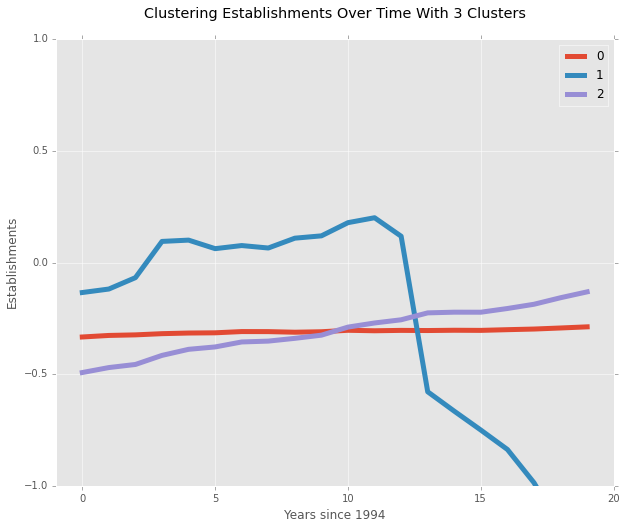

In [61]:
# perform clustering and plotting
knum = 3

fig = pl.figure(figsize=(10, 8))
pl.title('Clustering Establishments Over Time With 3 Clusters\n')

kmeans = KMeans(n_clusters=knum)
kmeans.fit(time.values)
for i in range(knum):
    pl.plot(kmeans.cluster_centers_[i], label = i, lw = 5)
    
pl.legend(loc='lower center')
pl.xlabel('Years since 1994')
pl.ylabel('Establishments')    
pl.legend(loc='upper right')
pl.xlabel('Years since 1994')
pl.ylabel('Establishments')
pl.xlim(-1,20)
pl.ylim(-1, 1)

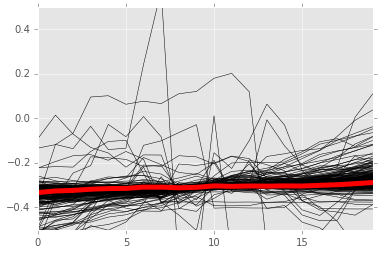

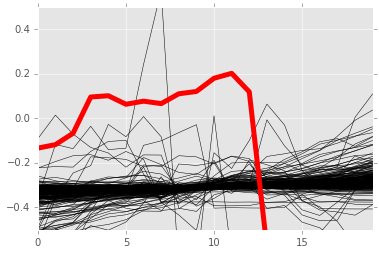

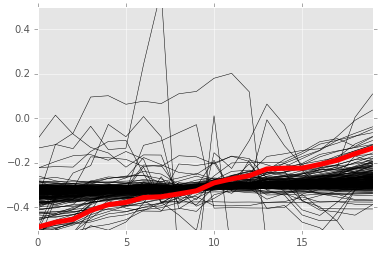

In [50]:
for j in range(kmeans.n_clusters):
    index = kmeans.labels_ == j
    pl.figure()
    for ii in range (0, len(time.values)):
            pl.plot(time.iloc[ii], color = 'k', lw = 0.5)
    pl.plot(kmeans.cluster_centers_[j], color = 'red', lw = 5)
    pl.xlim(0,19)
    pl.ylim(-.5,.5)

Three obvious groups emerge.  One group saw their establishments take a nose dive around 2001 when both the terrorist attacks and the dot com bubble burst hurt the economic scene.  The other clusters are for zip codes that showed almost no movement thorough the trend period.  These zip codes either had bad data or extremely consistent rates of establishing business.  Finally there are the areas that show a gradual monotonic increase throughout the trend period.  All other numbers of clusters produced repeats of these same trends  

My geopanda plotting function was behaving finickly.  It did not plot on my machine currectly.  But I verified with classmates that this i indeed the correct code.  Not sure why it is not working.

In [54]:
geo_merge = pd.DataFrame()
geo_merge['cluster'] = kmeans.labels_
geo_merge.plot(column = 'cluster', figsize=[12,12], categorical=True, legend=True, colormap = 'brg')

# Heirarchical Clustering¶


In [12]:
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
import numpy as np
np.set_printoptions(precision=5, suppress=True)

Create an array out of my time series

In [63]:
X = time.values

In [ ]:
Create the Linkage Matrix

In [64]:
Z = linkage(X, 'ward')
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

c, coph_dists = cophenet(Z, pdist(X))
c

0.55137673405668364

In [15]:
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

C:\Anaconda\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


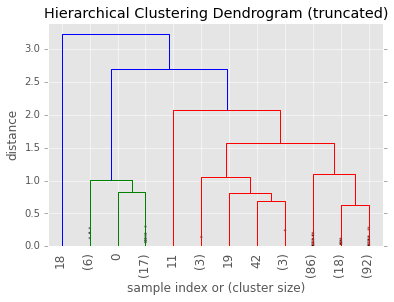

In [16]:
fancy_dendrogram(
    Z,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,  # useful in small plots so annotations don't overlap
)
plt.show()

In [17]:
from scipy.cluster.hierarchy import fcluster
max_d = 12
clusters = fcluster(Z, max_d, criterion='distance')

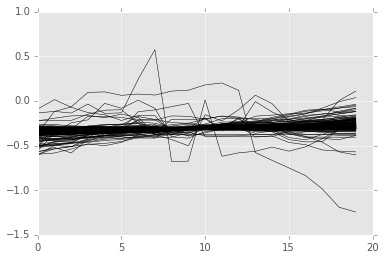

In [72]:
for j in range(6):
    index = clusters == j
    pl.figure()
    for ii in range (0, len(X)):
        if index[ii] == True:   
            pl.plot(X[ii], color = 'k', lw = 0.5)

Again, same problem with my mapping.  I hope it loads in your notebook, but I thin the code is correct.

In [73]:
geo_merge['cluster'] = clusters

TypeError: There is no line property "column"

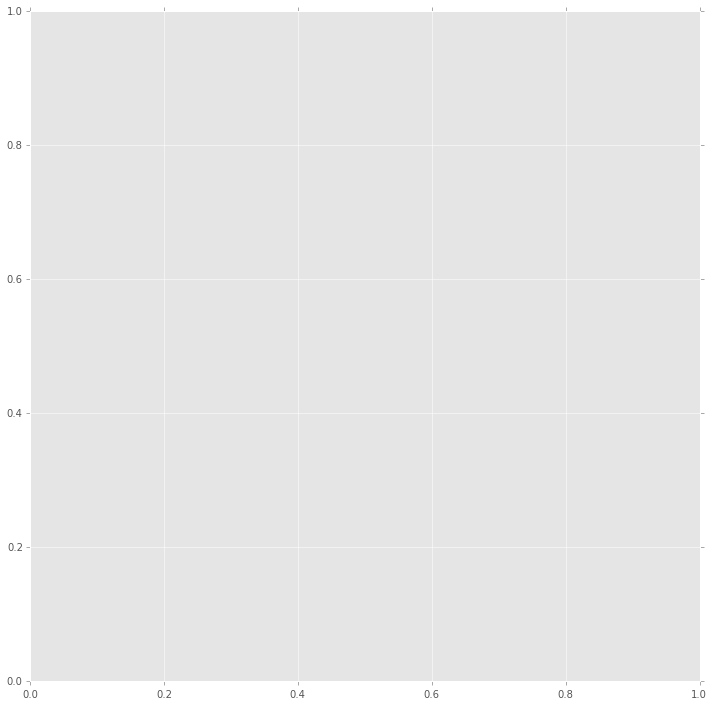

In [74]:
geo_merge.plot(column = 'cluster', figsize=[12,12], categorical=True, legend=True, colormap = 'brg')

Not a significant change with the clustering in terms of trends.  There are some zip codes where business establishment is monotonically increasing, there are others where precipitous drop offs occur, while in others there is virtually no change